# Classification of Algal Blooms

![plankton](Plankton.jpg)

## The problem 

Phytoplankton are single-celled algae that live in freshwater, saltwater, and everywhere in between. Algal blooms, big explosions of phytoplankton growth, happen naturally every late spring and early fall all around the globe. Sometimes, blooms grow out of control for a variety of reasons: excess of nutrient from land based runoff, influx of freshwater, higher than normal temperatures. These are called Harmful Algal Blooms (HABs). HABs pose a threat to human health and ecosystem health. 

![hab facts](download1.jpeg)

Early detection of algal blooms from imagery can help scientists and policy makers sample blooms as soon as possible to determine if they are toxic, and make important decisions regarding public health: beach closures, fisherman warnings, and seafood warnings can all help humans avoid harmful effects of HABS. My goal is to create a model that classifies algal blooms using imagery obtained from Google. Algal blooms come in all differnet shapes, sizes and colors, and this highly varied dataset will hopefully lead to a model that is able to classsify algal blooms in all forms. 

![bloom](bloom.jpg)

## Imports and Settings 

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import  PIL
from PIL import Image
import cv2
import time
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from numpy import loadtxt
from keras.models import load_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline

# custom function
from functions import *

Using TensorFlow backend.


## Image Preprocessing

The first step in my process was image preprocessing. This was an iterative process that I completed over several days. In summary the steps I took were as follows:

**Step 1: Splitting the data into folders**

This step was completed with a python script, split.py. I initially had the images split up into two folders: algae and not-algae. I created a new directory named split that contained an algae and not-algae folder and divided these images in 80/20/20 percentages across the train, test and validation folders, respectively.  

**Step 2: Resizing the images**

**Step 3: Rescaling the images**

**Step 4: Image Augmentation**

In [2]:
# get_img_stats is a function loaded in from data_cleaning.py
# it loops through each directory and gets the dimensions of each image and prints the minimum

test_algae = "split/test/algae/*"
test_not_algae = "split/test/not_algae/*"
get_img_stats(test_algae)
get_img_stats(test_not_algae)

train_algae = "split/train/algae/*"
train_not_algae = "split/train/not_algae/*"
get_img_stats(train_algae)
get_img_stats(train_not_algae)

val_algae = "split/validation/algae/*"
val_not_algae = "split/validation/not_algae/*"
get_img_stats(val_algae)
get_img_stats(val_not_algae)

images appended!
(140, 100)
images appended!
(160, 237)
images appended!
(140, 100)
images appended!
(153, 110)
images appended!
(140, 100)
images appended!
(200, 160)


In [3]:
# build a baseline data generator
train_dir = 'split/train/'
validation_dir = 'split/validation/'
test_dir = 'split/test/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(140, 140),
                                                    batch_size=32)

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(140, 140),
                                                        batch_size=32)
                                                        #class_mode='binary')

Found 867 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


## Modeling

### Build the model

In [4]:
# instantiate the model 
model = models.Sequential()

# you need alternating convolutional and pooling layers
# first kernel_size is 7x7 because my image size is > 128x128
# source: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

model.add(layers.Conv2D(32, (7, 7), activation='relu',
                        input_shape=(140, 140, 3))) # in the first layer add an input shape
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

# add in metrics for evaluations
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

### Train the model

In [8]:
# do not rerun this cell!! it takes an hour 
# remember to save your model after 
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 138s 1s/step - loss: 0.5877 - acc: 0.7078 - val_loss: 1.1311 - val_acc: 0.8162
Epoch 2/30
100/100 [==============================] - 117s 1s/step - loss: 0.4964 - acc: 0.7696 - val_loss: 0.1934 - val_acc: 0.8557
Epoch 3/30
100/100 [==============================] - 136s 1s/step - loss: 0.4058 - acc: 0.8145 - val_loss: 0.9803 - val_acc: 0.8729
Epoch 4/30
100/100 [==============================] - 123s 1s/step - loss: 0.4050 - acc: 0.8341 - val_loss: 0.1791 - val_acc: 0.8883
Epoch 5/30
100/100 [==============================] - 110s 1s/step - loss: 0.3645 - acc: 0.8416 - val_loss: 0.1200 - val_acc: 0.8196
Epoch 6/30
100/100 [==============================] - 134s 1s/step - loss: 0.3358 - acc: 0.8612 - val_loss: 0.2107 - val_acc: 0.8007
Epoch 7/30
100/100 [==============================] - 137s 1s/step - loss: 0.3240 - acc: 0.8627 - val_loss: 0.1071 - val_acc: 0.9107
Epoch 8/30
100/100 [==============================] - 135s 1s/step - 

### Model Evaluation

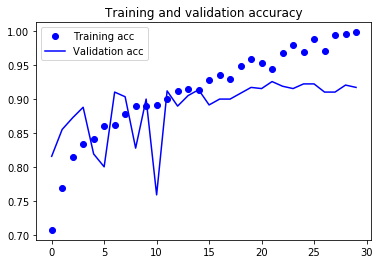

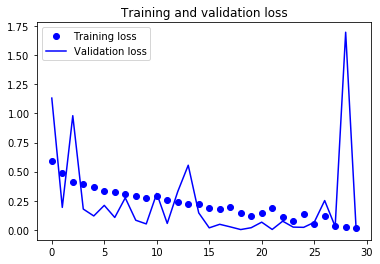

In [18]:
# to mass comment out: select all and ctrl + / 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Augment data for modeling

In [5]:
#augment the images
train_datagen = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=90, 
                                     brightness_range=[0.2,1.5], 
                                     horizontal_flip=True) 
                                                          

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(140, 140),
        batch_size=32)

validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        target_size=(140, 140), 
                                                        batch_size=32)

Found 867 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


### Fit model with augmented data

In [21]:
# do not re-run this cell!! it takes about an hour 
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 116s 1s/step - loss: 0.2769 - acc: 0.8959 - val_loss: 0.0249 - val_acc: 0.9141
Epoch 2/30
100/100 [==============================] - 131s 1s/step - loss: 0.2418 - acc: 0.9057 - val_loss: 0.4552 - val_acc: 0.9021
Epoch 3/30
100/100 [==============================] - 127s 1s/step - loss: 0.2689 - acc: 0.8996 - val_loss: 0.1425 - val_acc: 0.8969
Epoch 4/30
100/100 [==============================] - 113s 1s/step - loss: 0.2388 - acc: 0.9097 - val_loss: 0.0065 - val_acc: 0.9278
Epoch 5/30
100/100 [==============================] - 106s 1s/step - loss: 0.2388 - acc: 0.9084 - val_loss: 0.0139 - val_acc: 0.9261
Epoch 6/30
100/100 [==============================] - 110s 1s/step - loss: 0.2331 - acc: 0.9074 - val_loss: 0.0344 - val_acc: 0.9192
Epoch 7/30
100/100 [==============================] - 107s 1s/step - loss: 0.2228 - acc: 0.9118 - val_loss: 0.0052 - val_acc: 0.9364
Epoch 8/30
100/100 [==============================] - 107s 1s/step - 

In [22]:
# model.save("algae_model_2.h5")

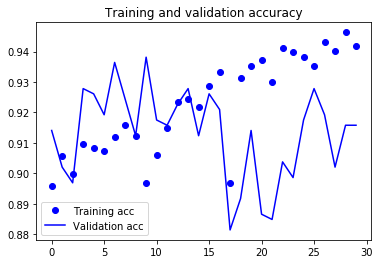

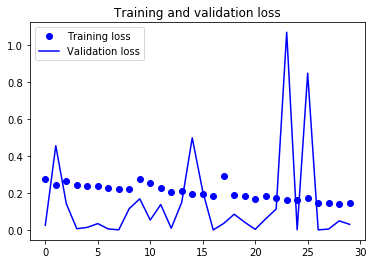

In [23]:
# to mass comment out: select all and ctrl + / 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Model Evaluation

In [6]:
# load the saved model
saved_model = load_model('algae_model_2.h5')

#### Accuracy of test set

In [16]:
# evaluate test accuracy
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(140, 140), 
                                                  batch_size=20)

test_loss, test_acc = saved_model.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)
print('test loss:', test_loss)

Found 288 images belonging to 2 classes.
test accuracy: 0.8558091521263123
test loss: 1.0412065982818604


#### Classification Metrics

In [9]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = saved_model.predict_generator(test_generator, steps=test_steps_per_epoch)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys()) 

In [10]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

       algae       0.49      0.54      0.52       149
   not_algae       0.45      0.40      0.43       139

    accuracy                           0.48       288
   macro avg       0.47      0.47      0.47       288
weighted avg       0.47      0.48      0.47       288



#### Confusion Matrix

Normalized confusion matrix
[[0.54362416 0.45637584]
 [0.5971223  0.4028777 ]]


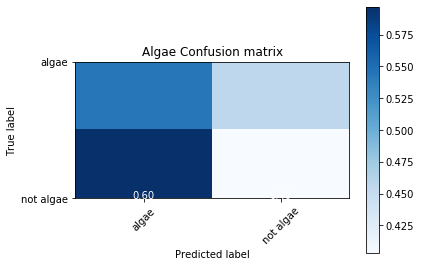

In [11]:
plot_confusion_matrix(confusion_matrix(true_classes, predicted_classes), classes=['algae', 'not algae'], normalize=True,
                      title='Algae Confusion matrix')

# Make a Predicition!

array([0])

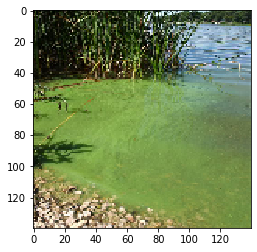

In [14]:
predict_image(saved_model, 'split/test/algae/download77.jpeg')

array([1])

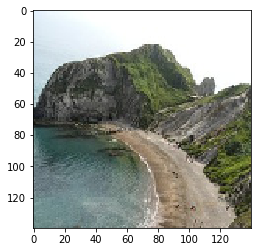

In [15]:
predict_image(saved_model, 'split/validation/not_algae/74484e48.jpg')

In [19]:
# images to predict 
# download77.jpeg
# download_2020-02-25T141451.520.jpeg
# download_2020-02-25T142938.088.jpeg
# download_020-02-25T153236.282.jpeg
# download_2020-02-28T135429.075.jpeg

# Conclusions

- Model accuracy for the test set is pretty good: 86% 
- Model loss is not great: 1.04 
- Model imporvments:
    - Add more data 
    - Manual cropping
    - Saturation adjustment
    - Add more types of augmentation 
    - Adjust model weights in an effort to decrease loss
    - Decrease epochs in an effort to decrease loss